In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
from pathlib import Path
import sys

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from setup import setup_dataset


train_dataset, test_dataset, metadata = setup_dataset('../dataset')

verification_image_dir = '../dataset/verification'
model_filename = 'dog_classifier.h5'
weights_filename = 'model.weights.h5'

<_FilterDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 517ms/step - accuracy: 0.4029 - loss: 0.6982 - val_accuracy: 0.6400 - val_loss: 1.9026
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 482ms/step - accuracy: 0.4651 - loss: 1.9260 - val_accuracy: 0.3600 - val_loss: 1.0322
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.3105 - loss: 9.8731 - val_accuracy: 0.6400 - val_loss: 41.1702
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 492ms/step - accuracy: 0.4976 - loss: 50.9507 - val_accuracy: 0.6300 - val_loss: 10.3828
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.3689 - loss: 253.2790 - val_accuracy: 0.6400 - val_loss: 92.6604
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.3433 - loss: 890.4904 - val_accuracy: 0.5800 - val_loss: 16.0033
Epoch 7/10


2024-12-07 11:33:46.984212: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 486ms/step - accuracy: 0.3657 - loss: 1985.8087 - val_accuracy: 0.6600 - val_loss: 198.6915
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.4671 - loss: 3450.2534 - val_accuracy: 0.6400 - val_loss: 5777.0376
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.4735 - loss: 12408.3369 - val_accuracy: 0.6400 - val_loss: 3425.9407
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.3783 - loss: 20003.1621 - val_accuracy: 0.6300 - val_loss: 4113.7339


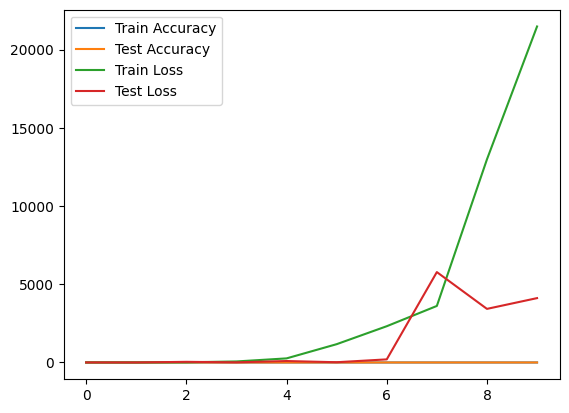

In [5]:
print(train_dataset)
num_classes = 5
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Number of classes
])

def preprocess(img, label):
    img = tf.image.resize(img, (224, 224))  # Größe anpassen
    img = img / 255.0  # Normalisierung
    return img, tf.one_hot(label, num_classes)  # One-Hot-Encoding der Labels

batch_size = 32
train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(1000)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    verbose=1
)

model.save_weights(weights_filename)
model.save(model_filename) 

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()


# Performancetest des Modells

In [6]:
model = load_model(model_filename)
print("Model loaded successfully!")

# Step 2: Define Class Labels
# Ensure these match the class labels used during training
class_labels = {
    0: "Chihuahua",
    1: "Maltese Dog",
    2: "Komondor",
    3: "German Shepherd",
    4: "African Hunting Dog"
}
print("Class labels:", class_labels)

# Step 3: Define Image Preprocessing Function
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess an image for prediction.
    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired image size (height, width).
    Returns:
        np.array: Preprocessed image ready for prediction.
    """
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img_array = img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Step 4: Predict Function
def predict_image(image_path):
    """
    Predict the class of an image.
    Args:
        image_path (str): Path to the image file.
    """
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=-1)[0]
    predicted_label = class_labels[predicted_class]

    # Display the image with its prediction
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()
    print(f"Predicted Label: {predicted_label}")

# Step 5: Test the Model with Example Images
# Update this with the path to your test image directory


for img in train_dataset:
    print(f"Testing image: {img}")
    predict_image(img)


Model loaded successfully!
Class labels: {0: 'Chihuahua', 1: 'Maltese Dog', 2: 'Komondor', 3: 'German Shepherd', 4: 'African Hunting Dog'}
Testing image: (<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.5375868 , 0.6390401 , 0.40134686],
         [0.53254485, 0.6331838 , 0.39793345],
         [0.53671104, 0.63475025, 0.40882996],
         ...,
         [0.58450395, 0.6903863 , 0.4903863 ],
         [0.5768652 , 0.67882603, 0.49339116],
         [0.58449763, 0.6864584 , 0.5021447 ]],

        [[0.55334735, 0.65138656, 0.42555568],
         [0.55512744, 0.65316665, 0.4297248 ],
         [0.5788078 , 0.67680323, 0.46124825],
         ...,
         [0.572325  , 0.67820734, 0.47820732],
         [0.58034843, 0.69015235, 0.4979079 ],
         [0.5857756 , 0.6955796 , 0.50338906]],

        [[0.61103415, 0.706386  , 0.4987617 ],
         [0.64745796, 0.7428099 , 0.5351856 ],
         [0.611076  , 0.7051937 , 0.50664675],
         ...,
         [0.5723302 , 0.68089986, 0

TypeError: path should be path-like or io.BytesIO, not <class 'tuple'>